In [1]:
import numpy as np
import pandas as pd
import scipy.stats

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Exploring Maximum Likelihood

In this exercise we're going to explore the concept of maximum likelihood estimation (MLE).

Maximum likelihood estimation is the gold standard methodology for estimating some true parameter from a data set.  For example:

  - We have a coin of unknown fairness, and we want to flip the coin a bunch of times and use the results to figure out the fairness of the coin (first example).
  - We have a chunk of matter that is undergoing radioactive decay (the atoms in the material spontaneously self-destruct at some rate), and we would like to figure out the rate of decay (second example).
  
We will start by using MLE to figure choose between a finite number of possibilities (the truth is one of these ten things, which one of the possibilities is most likely), and will then generalize the method to choosing between an infinite number of possibilities.

# Coin Flips

Let's start with the most mundane (but instructive) example, *flipping coins*!

1. Write a function `flip_coin` that returns an array of zeros and ones representing a sequence of `n` flips of a coin of fairness `p`.

```python
def flip_coin(n: int, p: float) -> np.array:
    """Flip a coin of fairness p, n times."""
    pass
```

In [2]:
def flip_coin(n: int, p: float) -> np.array:
    """Flip a coin of fairness p, n times."""
    return np.random.binomial(1, p, size=n)

The likelihood function is a measure of how reasonable a given value of `p` is given some observed data.  It is defined as the probability of observing sequence of coin flips $\{f_1, f_2, \ldots, f_k\}$, given some value of `p`:

$$ \text{likelihood}(p; \{f_1, f_2, \ldots, f_n\}) = \prod_i P(f_i \mid p) $$

Since we're doing coin flips, the probabilities in question are:

$$ P(f_i \mid p) = \begin{cases} 
    p, & \mbox{if } f_i = 1 \\
    1 - p, & \mbox{if } f_i = 0 \end{cases} $$

2. Write a function `coin_log_likelihood` that returns the *logarithm* of the likelihood of `p` given a sequence of coin flips.

```python
def coin_log_likelihood(p: float, flips: np.array) -> float:
    """Return the negative log-likelihood of a parameter p given a sequence of coin flips.
    """
```

In [3]:
def coin_log_likelihood(p: float, flips: np.array) -> float:
    return np.sum(np.log(np.array([1 - p, p])[flips]))

Let's suppose we flip a coin from a bag of coins of unknown origin ten times, and we get the following results:

```
H, T, T, T, H, H, T, T, T, T
```

3. Create a numpy array `flip_data` representing this sequence of coin flips.

In [4]:
flip_data = np.array([1, 0, 0, 0, 1, 1, 0, 0, 0, 0])

4. Suppose the are *two* coins in the bag, and we are provided with the knowledge that:

$$ p_{\text{coin 1}} = 0.25 $$
$$ p_{\text{coin 2}} = 0.5 $$

Use your function to compute the *log-likelihood* of each of these coins given the sequence of coin flips.  Which coin is more likely the one you chose and flipped?  Does this align with your intuition?

In [5]:
coin_log_likelihood(p=0.25, flips=flip_data)

-6.172657590522138

In [6]:
coin_log_likelihood(p=0.5, flips=flip_data)

-6.931471805599453

5. Make a bar chart of these two probabilities.  Here's how the resulting chart should look.

In [7]:
def plot_coin_likelihood(ax: matplotlib.axes.Axes, 
                         ps: np.array,
                         data: np.array) -> None:
    xs = np.arange(len(ps))
    xlabels = [str(p) for p in ps]
    likelihoods = [coin_log_likelihood(p=p, flips=data) 
                   for p in ps]
    ax.bar(xs, likelihoods, align='center', alpha=0.5)
    ax.set_xticks(xs)
    ax.set_xticklabels(xlabels)
    ax.set_xlabel("$p$")
    ax.set_ylabel("Binomial Likelihood")
    ax.set_title(",".join(np.array(['T', 'H'])[data]))

In [8]:
probabilities = [0.25, 0.5]

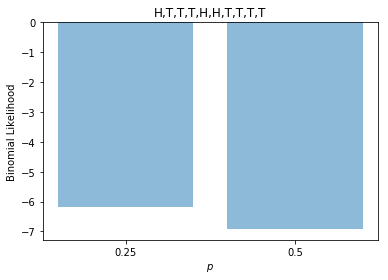

In [9]:
fig, ax = plt.subplots(figsize=(6, 4))

plot_coin_likelihood(ax, ps=probabilities, data=flip_data)

6. Wrap your plotting code in a function so that you can continue to use it.

```python
def plot_coin_likelihood(ax: matplotlib.axes.Axes, 
                         ps: np.array,
                         data: np.array) -> None:
```

6. Make a plot of the likelihood for each *truncated* sequence of flips.  That is:

```
First plot for: H
Second plot for: H, T
Third plot for: H, T, T
Fourth plot for: H, T, T, T,
...
Tenth plot for: H, T, T, T, H, H, T, T, T, T
```

You'll find the function you wrote earlier useful.  The result should look like:

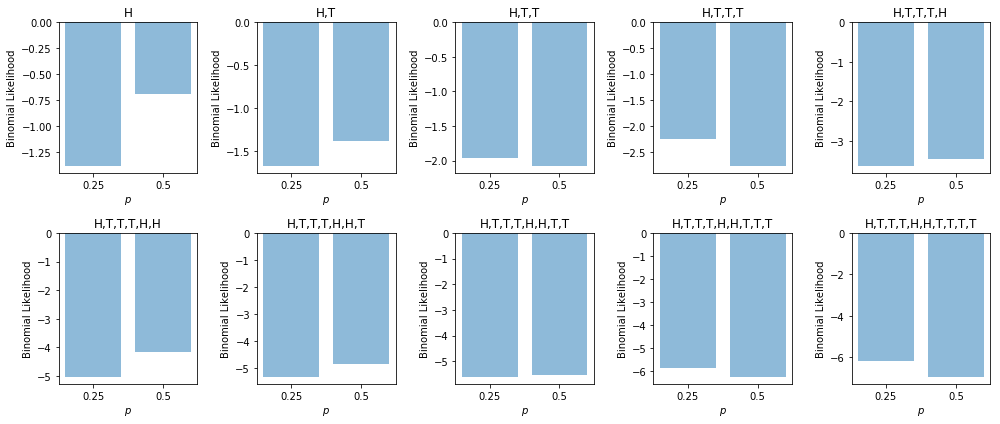

In [10]:
fig, axs = plt.subplots(2, 5, figsize=(14, 6))

for idx, ax in enumerate(axs.flatten(), start=1):
    plot_coin_likelihood(ax, data=flip_data[:idx], ps=probabilities)
fig.tight_layout()

7. Spend some time discussion with your partner how the likelihood of each possibility evolves as we flip the coin more and more.  Does the evolution make sense to you?

In [11]:
probabilities = [0.1, 0.25, 0.5, 0.75, 0.9]

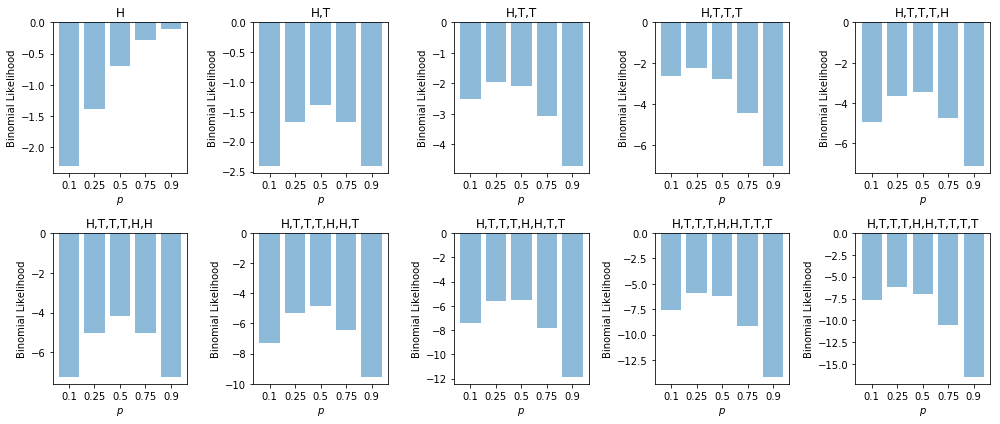

In [12]:
fig, axs = plt.subplots(2, 5, figsize=(14, 6))

for idx, ax in enumerate(axs.flatten(), start=1):
    plot_coin_likelihood(ax, data=flip_data[:idx], ps=probabilities)
    ax.set_title(",".join(np.array(['T', 'H'])[flip_data[:idx]]))
fig.tight_layout()

8. Repeat the experiment for a wider set of possible probabilities:
    
```python
probabilities = np.linspace(0, 1, num=11)
```

/Users/matthewdrury/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


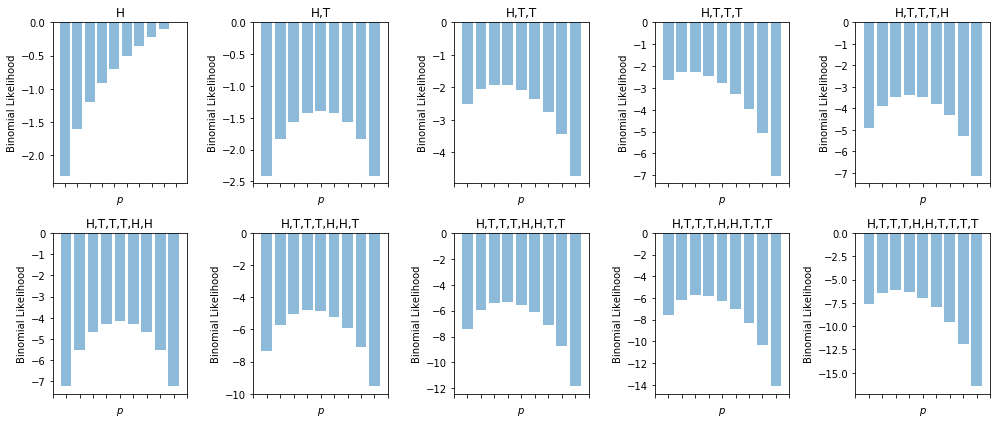

In [13]:
probabilities = np.linspace(0, 1, num=11)

fig, axs = plt.subplots(2, 5, figsize=(14, 6))

for idx, ax in enumerate(axs.flatten(), start=1):
    plot_coin_likelihood(ax, data=flip_data[:idx], ps=probabilities)
    ax.set_title(",".join(np.array(['T', 'H'])[flip_data[:idx]]))
    ax.set_xticklabels([])
fig.tight_layout()

Now let's generalize the above ideas to an *infinite* set of probabilities, i.e. let's find the maximum likelihood out of *all* the possible probabilities:

$$ 0 \leq p \leq 1 $$

9. Write a function `plot_coin_likelihood_continuous` that is much like your previous `plot_coin_likelihood` function, but draws a **line** plot (i.e. the graph of a function) over the entire range of probabilities.  You won't need to pass in an array of probabilities to this one:

```python
def plot_coin_likelihood_continuous(matplotlib.axes.Axes, 
                                    data: np.array) -> None:
```

In [14]:
def plot_coin_likelihood_continuous(ax, data):
    ps = np.linspace(0, 1, num=100)
    likelihoods = [coin_log_likelihood(p=p, flips=data) for p in ps]
    ax.plot(ps, likelihoods)
    ax.set_xlabel("$p$")
    ax.set_ylabel("Binomial Likelihood")
    ax.set_title(",".join(np.array(['T', 'H'])[data]))

10. Use your function to plot like likelihood function for the full sequence of flips.  You result should look something like this:

/Users/matthewdrury/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


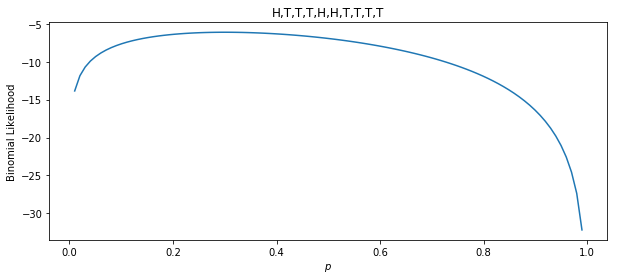

In [15]:
fig, ax = plt.subplots(figsize=(10, 4))

plot_coin_likelihood_continuous(ax, flip_data)

This plot is the graph on the **log-likelihood function** for the coin flipping experiment.  The **principle of maximum likelihood** states that the best estimate of the true fairness of the coin in the **maximum** of this function.

11. Write a function `maximum_coin_likelihood` that computes the maximum likelihood estimate of the coin fairness.  You'll need to use the `np.argmax` function (check out the numpy documentation to see what it does).

In [16]:
def maximum_coin_likelihood(data: np.array) -> float:
    ps = np.linspace(0, 1, num=100)
    likelihoods = [coin_log_likelihood(p=p, flips=data) for p in ps]
    max_likelihood_idx = np.argmax(likelihoods)
    return ps[max_likelihood_idx]

In [17]:
max_likelihood_estimate = maximum_coin_likelihood(flip_data)
print(f"The Maximum Likelihood Estimate is: {max_likelihood_estimate:2.2f}")

The Maximum Likelihood Estimate is: 0.30


/Users/matthewdrury/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


12. Compute the maximum likelihood estimate of `p` for this sequence of coin flips.  Re-draw your plot of the likelihood function from before, but superimpose a vertical line at the maximum likelihood estimate.

In [18]:
def plot_coin_likelihood_continuous(ax, data):
    ps = np.linspace(0, 1, num=100)
    likelihoods = [coin_log_likelihood(p=p, flips=data) for p in ps]
    max_like_estimate = ps[np.argmax(likelihoods)]
    ax.plot(ps, likelihoods)
    ax.axvline(max_like_estimate, color='orange')
    ax.set_xlabel("$p$")
    ax.set_ylabel("Binomial Likelihood")
    ax.set_title(",".join(np.array(['T', 'H'])[data]))

/Users/matthewdrury/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


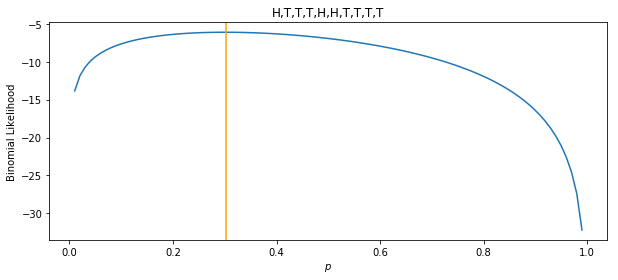

In [19]:
fig, ax = plt.subplots(figsize=(10, 4))

plot_coin_likelihood_continuous(ax, flip_data)

13. Make a plot of the complete likelihood function for each truncated sequence of coin flips, and superimpose the vertical line at the maximum likelihood estimate.

/Users/matthewdrury/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


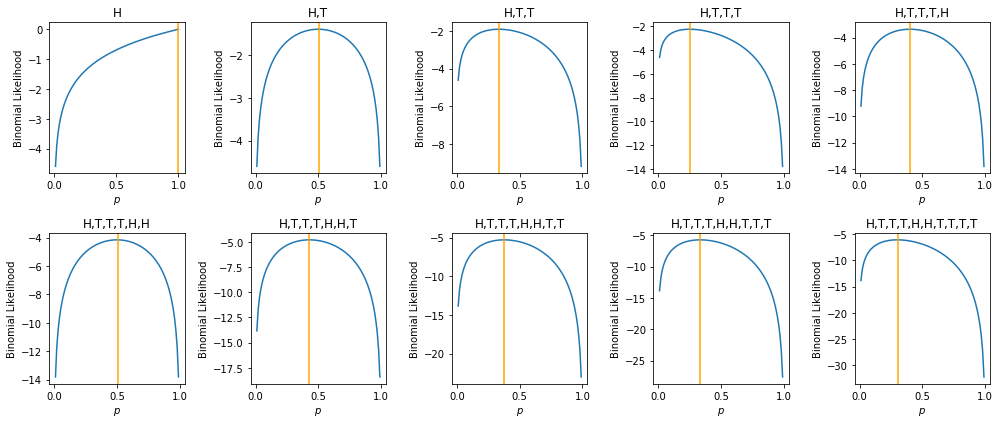

In [20]:
fig, axs = plt.subplots(2, 5, figsize=(14, 6))

for idx, ax in enumerate(axs.flatten(), start=1):
    plot_coin_likelihood_continuous(ax, data=flip_data[:idx])

fig.tight_layout()

15. Can you spot a pattern in the results for the various maximum likelihood estimates?  Do you have any conjectures for (a formula for) the maximum likelihood estimate of `p` in this situation?

16. **Wicked Bonus**: Prove your conjecture.

# Poisson Rate Estimation

In this example we will give another example of maximum likelihood estimation, this time using data from a real life experiment (and an important one at that!).

In 1919 [Ernest Rutherford](https://en.wikipedia.org/wiki/Ernest_Rutherford) completed an important experiment on the radioactive decay of atoms.  In radioactive decay (actually a particular type of radioactive decay called $\alpha$-decay), a (more or less) inert chunk of matter spontaneously emits an $\alpha$-particle.  It's impossible to predict exactly when this decay will happen, but the process does have some regularities.  It is the structure of these regularities that was discovered by Rutherford in this experiment.

Rutherford observed a chunk of [radium](https://en.wikipedia.org/wiki/Radium) of a fixed and well measured mass for a fixed amount of time and then counted how many radioactive events he observed over that span of time.  He then repeated this experiment 2612 times, each time taking record of how many events he observed.

The following numpy array contains Rutherford's data.

```python
alpha_particle_counts = np.array([
    57, 203, 383, 525, 532, 408, 273, 139, 49, 27, 10, 4, 2, 0])
```

For example, there were 57 periods of time where no event was observed, 203 periods where exactly one was observed, 383 where exactly two, and so on.

In [21]:
alpha_particle_counts = np.array([57, 203, 383, 525, 532, 408, 273, 139, 49, 27, 10, 4, 2, 0])

1. Make a histogram of Rutherford's data.  You should have one bar for each observed count (using `ax.hist` will almost certainly do the wrong thing here, so you should manually construct a bar chart).

Text(0,0.5,'Number of Times Count was Observed')

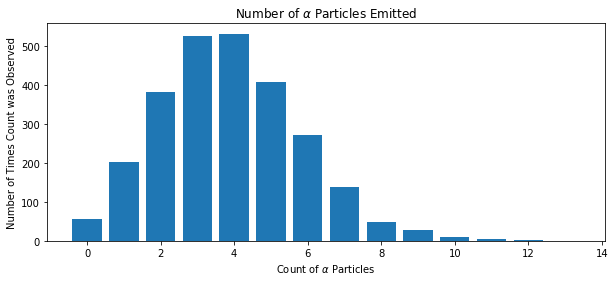

In [22]:
fig, ax = plt.subplots(figsize=(10, 4))

xs = np.arange(len(alpha_particle_counts))
ax.bar(xs, alpha_particle_counts)
ax.set_title(r"Number of $\alpha$ Particles Emitted")
ax.set_xlabel(r"Count of $\alpha$ Particles")
ax.set_ylabel("Number of Times Count was Observed")

2. Do you have any conjectures for the distribution of this data.  Keep in mind that it is descrete data describing a count.

3. The Poisson distribution is the most well know distribution used to describe count data.

You can play around with the Poisson distribution by importing `scipy.stats.poisson`.  It has one parameter $\lambda$ that describes the rate of occurrences of an event.

3. The log-likelihood function of the Poisson distribution is

$$ \text{log-likelihood-poisson}(\lambda; \{k_i\}) = - N \lambda + \log(\lambda) \sum_i k_i + \text{constant}$$

Where $\{k_i\}$ are the observed counts in our data, $N$ is the number of data points we have observed, and the constant does not depend of the parameter $\lambda$.  

Plot the log likelihood function of Rutherford's data for a grid of $\lambda$'s in the range $[0, 12]$ (you can assume the constant is zero, doing otherwise just moves the graph up and down).

In [23]:
def poisson_likelihood(lam, data):
    log_lik = np.sum(count*np.log(scipy.stats.poisson(lam).pmf(k))
                     for k, count in enumerate(data))
    return log_lik

Text(0,0.5,'Log-Likelihood')

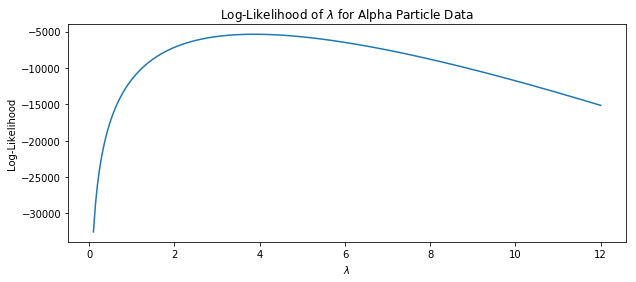

In [24]:
fig, ax = plt.subplots(figsize=(10, 4))

lams = np.linspace(0.1, 12.0, num=250)
likelihoods = [poisson_likelihood(lam=lam, data=alpha_particle_counts)
               for lam in lams]
ax.plot(lams, likelihoods)
ax.set_title(r"Log-Likelihood of $\lambda$ for Alpha Particle Data")
ax.set_xlabel(r"$\lambda$")
ax.set_ylabel("Log-Likelihood")

5. Calculate the maximum likelihood estimate of the rate of alpha decay $\lambda$ from Rutherford's experiment.  Superimpose a vertical line at the maximum likelihood estimate of $\lambda$.

In [25]:
max_likelihood_idx = np.argmax(likelihoods)
max_likelihood_estimate = lams[max_likelihood_idx]

Text(0,0.5,'Log-Likelihood')

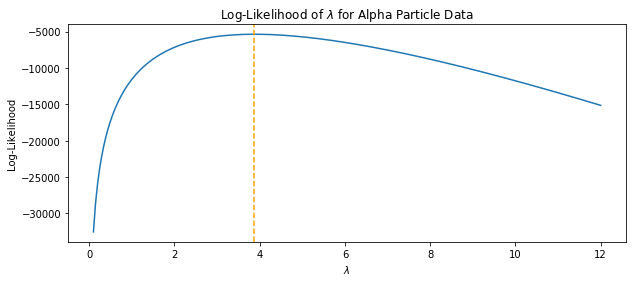

In [26]:
fig, ax = plt.subplots(figsize=(10, 4))

lams = np.linspace(0.1, 12.0, num=250)
likelihoods = [poisson_likelihood(lam=lam, data=alpha_particle_counts)
               for lam in lams]
ax.plot(lams, likelihoods)
ax.axvline(max_likelihood_estimate, color='orange', linestyle='--')
ax.set_title(r"Log-Likelihood of $\lambda$ for Alpha Particle Data")
ax.set_xlabel(r"$\lambda$")
ax.set_ylabel("Log-Likelihood")

6. Make note of what we just did: we fit a **distribution** to Rutherford's data.  To check the goodness of fit, we can plot both the fit distribution (a Poisson in this case) and the original data on the same plot.

Here's an example with some simulated data:

In [27]:
def explode_array_of_counts(count_data):
    return np.repeat(np.arange(len(count_data)), count_data)

In [28]:
raw_alpha_particle_counts = explode_array_of_counts(count_data=alpha_particle_counts)

In [29]:
raw_alpha_particle_counts

array([ 0,  0,  0, ..., 11, 12, 12])

In [30]:
alpha_particle_poisson_mle = np.mean(raw_alpha_particle_counts)

In [31]:
alpha_particle_poisson_mle

3.8767228177641653

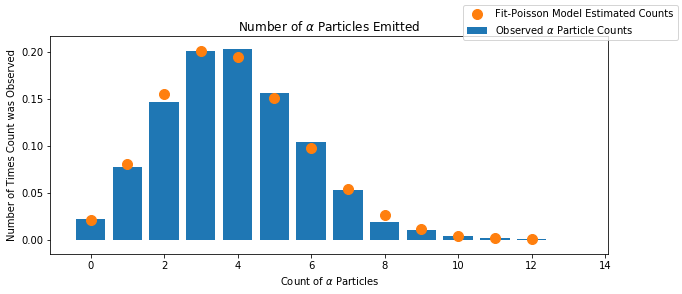

In [32]:
fig, ax = plt.subplots(figsize=(10, 4))

xs = np.arange(len(alpha_particle_counts))
ax.bar(xs, alpha_particle_counts / np.sum(alpha_particle_counts), 
       zorder=1, label=r"Observed $\alpha$ Particle Counts")
ax.set_title(r"Number of $\alpha$ Particles Emitted")
ax.set_xlabel(r"Count of $\alpha$ Particles")
ax.set_ylabel("Number of Times Count was Observed")

x = np.arange(0, 13)
ax.scatter(x, scipy.stats.poisson(alpha_particle_poisson_mle).pmf(x),
           s=100, zorder=2, label="Fit-Poisson Model Estimated Counts")

fig.legend()

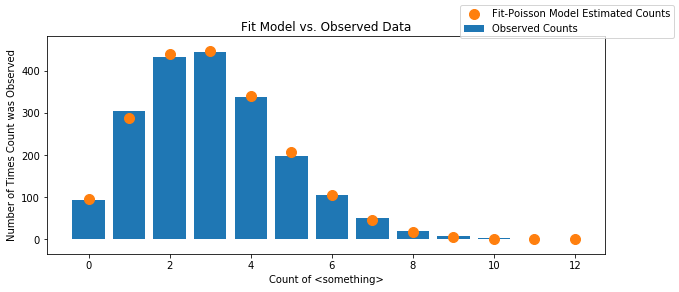

In [33]:
data = scipy.stats.poisson(3).rvs(2000)
_, counts = np.unique(data, return_counts=True)

poisson_mle = np.mean(data)


fig, ax = plt.subplots(figsize=(10, 4))

xs = np.arange(len(counts))
ax.bar(xs, counts, 
       zorder=1, label=r"Observed Counts")
ax.set_title(r"Fit Model vs. Observed Data")
ax.set_xlabel(r"Count of <something>")
ax.set_ylabel("Number of Times Count was Observed")

x = np.arange(0, 13)
ax.scatter(x, 2000*scipy.stats.poisson(poisson_mle).pmf(x),
           s=100, zorder=2, 
           label="Fit-Poisson Model Estimated Counts")

fig.legend()

7. The **law of small numbers** (non-canonical, yet clever, name) states that binomial distribution with a very large $N$ and a very small $p$ are very well approximated by Poisson distributions.

Given that a chunk of Radon is made of a very large number of individual Radon atoms, does the Law of Small Numbers explain your results in this section?

Reference: [Caltech Lesson on the Law Small Numbers](http://www.math.caltech.edu/~2016-17/2term/ma003/Notes/Lecture12.pdf)